In [77]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model_id = "gmguarino/ModernBERT-large-climateguard"

model = AutoModelForSequenceClassification.from_pretrained(model_id)
tokenizer = AutoTokenizer.from_pretrained(model_id)


In [78]:
CHUNK_SIZE = 512
CHUNK_OVERLAP = 256

In [79]:
for parameter in model.parameters():
    parameter.requires_grad = False

In [80]:
import pandas as pd
from datasets import load_dataset, Dataset
from llama_index.core.node_parser import SentenceSplitter

splitter = SentenceSplitter(
    chunk_size=CHUNK_SIZE,
    chunk_overlap=CHUNK_OVERLAP,
)

dataset_id = "DataForGood/climateguard"
# Load raw dataset
dataset = load_dataset(dataset_id, split="test")

records = []
for idx, record in enumerate(dataset):
    chunks = splitter.split_text(record["plaintext"].lower().replace(".", "").replace(",", ""))
    for chunk in chunks:
        records.append(
            {
                "id": idx,
                "text": chunk,
                "label": int(record["misinformation"]),
            }
        )

claims_dataset = Dataset.from_pandas(pd.DataFrame.from_records(records))

In [81]:
claims_dataset[0]

{'id': 0,
 'text': "alors on vous entend super mal donc je vous disais vous passez tous les jours à côté de changé la bad not les e allons aujourd' hui un niveau infrastructure si on ne veut pas de grosses grosses entreprises qui partiront comme des entreprises pharmaceutiques convoqué dans le cadre qui abordent aujourd' hui dès huit mille salariés pas de bêtise ça rit ça brise la ligne malheureusement allez sont allez mauvais un on enjeu est un économique enjeu très économique très fort et on peut parvenir on ne peut pas revenir en arrière on est désolés favorisant la ligne était trop mauvais on intervenait avec louis alors de senlis en haute-garonne il est conducteur d' engins bonjour louis un beau jour toute l' équipe conducteurs d' engins vous étiez sur euh sur le chantier d' autoroute justement louis non pas tout à fait sur des plateformes je produis des produits euh justement pour faire des des secousses on a tout ce qui ce est qui démolition est j' aurais démolition pu j' traite

In [82]:
# # Tokenize helper function
# def tokenize(batch):
#     return tokenizer(
#         batch["text"],
#         # padding="max_length",
#         truncation=True,
#         max_length=CHUNK_SIZE,
#         return_tensors="pt",
#     )


def format_labels(example):
    return {"label": int(example["label"])}


claims_dataset = claims_dataset.map(format_labels, batched=False)



Map:   0%|          | 0/224 [00:00<?, ? examples/s]

In [83]:
import os

from openai import OpenAI
from dotenv import load_dotenv

load_dotenv(override=True)
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

_system_prompt = """You are an assistant helping editors to moderate TV and radio content.
You will be provided with a transcript delimited by triple backticks.
Bear in mind that the transcript may be missing punctuation and may be of very low quality, with incorrect vocabulary, cuts in the wrong places, or may include some phonetic transcription.

Does the text promote climate change misinformation that undermines well-established scientific consensus, such as denying the existence of climate change or the factors that contribute to it ?

Answer just a number on a scale of 0 - does not promote - to 10 - certainly promotes.

text:"""

In [84]:
import re

def parse_response(response: str):
    """Parse response containing only a score."""
    match = re.match(r"^[^\d]*(\d+)", response)
    if match:
        score = int(match.group(1))  # Extract score as an integer
    else:
        score = 0
    return int(score >= 8)

In [85]:
import torch
from tqdm.notebook import tqdm

predictions = []
openai_predictions = []
labels = []
outputs = []

with torch.no_grad():
    # for record in tokenized_dataset:
    for record in tqdm(claims_dataset):
        inputs = tokenizer(
            record["text"],
            # padding="max_length",
            truncation=True,
            max_length=CHUNK_SIZE,
            return_tensors="pt",
        )
        prompt = _system_prompt + f" '''{record["text"]}'''"
        messages = [{"role": "user", "content": prompt}]

        output = model(inputs["input_ids"], inputs["attention_mask"])
        response = client.chat.completions.create(
            model="ft:gpt-4o-mini-2024-07-18:personal::B1xWiJRm",
            messages=messages,
            temperature=0,
        )
        result = response.choices[0].message.content.strip()
        outputs.append(output.logits[0])
        predictions.append(output.logits.numpy().argmax(1)[0])
        openai_predictions.append(parse_response(result))


  0%|          | 0/224 [00:00<?, ?it/s]

In [86]:
df = claims_dataset.to_pandas()
df["predictions"] = predictions
df["openai_predictions"] = openai_predictions
df = df.groupby(["id"]).agg("max").drop(columns="text")

In [87]:
from sklearn.metrics import classification_report
print("OpenAI")
print(classification_report(df.label, df.openai_predictions))
print("ModernBERT")
print(classification_report(df.label, df.predictions))

OpenAI
              precision    recall  f1-score   support

           0       0.78      0.34      0.47        74
           1       0.44      0.84      0.58        45

    accuracy                           0.53       119
   macro avg       0.61      0.59      0.52       119
weighted avg       0.65      0.53      0.51       119

ModernBERT
              precision    recall  f1-score   support

           0       0.68      0.28      0.40        74
           1       0.40      0.78      0.53        45

    accuracy                           0.47       119
   macro avg       0.54      0.53      0.46       119
weighted avg       0.57      0.47      0.45       119



In [88]:
display(df.openai_predictions.value_counts())
display(df.predictions.value_counts())

openai_predictions
1    87
0    32
Name: count, dtype: int64

predictions
1    88
0    31
Name: count, dtype: int64

<Axes: ylabel='Density'>

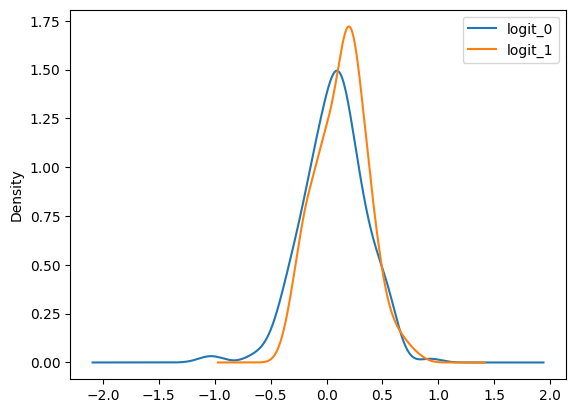

In [89]:
pd.DataFrame(outputs, columns=["logit_0", "logit_1"]).map(lambda x: x.numpy()).plot(kind="kde")

In [ ]:
openai_predictions counts
1    87
0    32
Name: count, dtype: int64

modernbert predictions counts
1    88
0    31
Name: count, dtype: int64

SyntaxError: invalid syntax (2416865998.py, line 2)